## Introduction

##### The purpose of this notebook is to analyze data to answer the question of whether school performance (measured by ACT scores) is predicted by socioeconomic factors.

This notebook mainly utilizes the data set that was previously cleaned *(final_clean_education_inequality_data.csv)*, along with a new data set from the National Center of Education Statistics *(internet.csv)* to determine whether ACT scores are also predicted by students' access to a computer or internet at home.

## Import libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Import additional libraries

## Load clean data

##### $\rightarrow$ Load the clean data set from Github.

In [73]:
df = pd.read_csv('https://raw.githubusercontent.com/siennamart/Education-Inequality-Project/main/SM_Education_Inequality_Data_Preparation%20(4).csv')

In [74]:
internet = pd.read_csv('https://raw.githubusercontent.com/siennamart/Education-Inequality-Project/main/Internet%20(1).csv')

##### $\rightarrow$ Review the contents of the data set.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7871 entries, 0 to 7870
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7871 non-null   int64  
 1   rate_unemployment  7871 non-null   float64
 2   percent_college    7871 non-null   float64
 3   percent_married    7871 non-null   float64
 4   median_income      7871 non-null   float64
 5   average_act        7871 non-null   float64
 6   percent_lunch      7871 non-null   float64
 7   zip_code           7871 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 492.1 KB


In [38]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,zip_code
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,19804
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,19709
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,19709
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,19958
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,19934


In [39]:
df.describe()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,zip_code
count,7.871000e+03,7871.000000,7871.000000,7871.000000,7871.000000,7871.000000,7871.000000,7871.000000
mean,3.325872e+11,0.097880,0.569375,0.635583,52185.226655,20.219273,0.418002,44883.854148
std,1.324853e+11,0.057702,0.165655,0.194938,24168.800849,2.528848,0.238345,24053.429838
min,1.000016e+11,0.000000,0.091493,0.000000,3589.000000,12.362637,-0.054545,1001.000000
25%,2.105115e+11,0.058505,0.451339,0.526274,36801.500000,18.663004,0.237635,28447.500000
50%,3.600086e+11,0.085205,0.555747,0.668715,47013.000000,20.400000,0.378882,45246.000000
75%,4.700001e+11,0.122601,0.677110,0.777778,61530.500000,21.935287,0.570412,62361.500000
max,5.605830e+11,0.576125,1.000000,1.000000,226181.000000,32.362637,0.998729,99403.000000


##### $\rightarrow$ Review Internet Data


In [40]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   STATEFP      6930 non-null   int64 
 1   GEOID        6930 non-null   int64 
 2   NAME         6930 non-null   object
 3   CDP02_92E    6930 non-null   int64 
 4   OBJECTID     6930 non-null   int64 
 5   NCESID       6930 non-null   int64 
 6   STATEABBREV  6930 non-null   object
dtypes: int64(5), object(2)
memory usage: 379.1+ KB


In [41]:
internet.head()

,STATEFP,GEOID,NAME,CDP02_92E,OBJECTID,NCESID,STATEABBREV
0,10,1000080,Appoquinimink School District,6340,3617,1000080,DE
1,10,1000170,Cape Henlopen School District,2995,3618,1000170,DE
2,10,1000180,Caesar Rodney School District,4510,3619,1000180,DE
3,10,1000190,Capital School District,4610,3620,1000190,DE
4,10,1000200,Christina School District,12875,3621,1000200,DE


In [42]:
# Remove unnecessary columns
internet = internet[['NCESID','CDP02_92E']]

In [43]:
# Rename columns
internet = internet.rename(columns={"NCESID":"id",
              "CDP02_92E":"comp_int_access"})

In [44]:
internet.head()

,id,comp_int_access
0,1000080,6340
1,1000170,2995
2,1000180,4510
3,1000190,4610
4,1000200,12875


In [45]:
internet['merge_id'] = internet['id'].astype(str).str[:7]
df['merge_id'] = df['id'].astype(str).str[:7]
merged_df = pd.merge(internet, df, on='merge_id', how='inner')

In [46]:
internet_df = merged_df

In [61]:
merged_df.head()

,id_x,comp_int_access,merge_id,id_y,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,zip_code
0,1000080,6340,1000080,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,19709
1,1000080,6340,1000080,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,19709
2,1000170,2995,1000170,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,19958
3,1000180,4510,1000180,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,19934
4,1000190,4610,1000190,100019000050,0.080120,0.673492,0.483333,50649.0,17.034188,0.425118,19904


In [47]:
internet_df = internet_df[['id_y','rate_unemployment','percent_college','percent_married','median_income','average_act','percent_lunch','comp_int_access','zip_code']]

In [48]:
internet_df = internet_df.rename(columns={"id_y":"id"})

## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.


*  How do various socioeconomic factors influence ACT score?
- How does access to internet influence ACT score?
- How does having a college educated parent influence ACT scores?




## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

### Regression Analysis

In [49]:
df.columns

Index(['id', 'rate_unemployment', 'percent_college', 'percent_married',
       'median_income', 'average_act', 'percent_lunch', 'zip_code',
       'merge_id'],
      dtype='object')

Below is the code used to train our regression model

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[['median_income', 'rate_unemployment', 'percent_college', 'percent_lunch', 'percent_married']]
y = df['average_act']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create linear regression object
reg = LinearRegression()

# Train the model using the training sets
reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 7.19803240e-07 -2.79538171e+00  1.69665376e+00 -7.38035587e+00
 -1.00940437e-01]
Mean squared error: 2.38
Coefficient of determination: 0.63


Below is a regression analysis that uses a train and test model to calculate the predicted ACT scores based on socioeconomic factors and compared the to the actul average ACT scores.

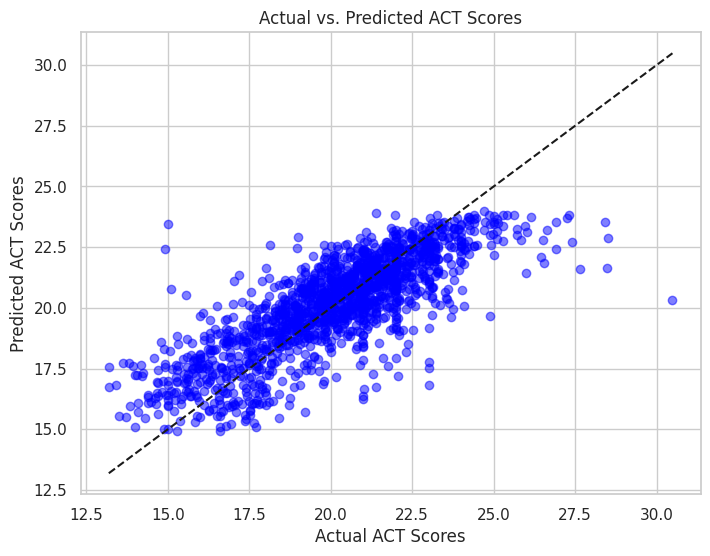

In [58]:
plt.figure(figsize=(8, 6))


plt.scatter(y_test, y_pred, color='blue', alpha=0.5)


plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

plt.xlabel('Actual ACT Scores')
plt.ylabel('Predicted ACT Scores')
plt.title('Actual vs. Predicted ACT Scores')


plt.show()

In [69]:
import statsmodels.api as sm

X = sm.add_constant(df[['median_income', 'rate_unemployment', 'percent_college', 'percent_lunch', 'percent_married']])
y = df['average_act']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     2544.
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        03:51:48   Log-Likelihood:                -14684.
No. Observations:                7871   AIC:                         2.938e+04
Df Residuals:                    7865   BIC:                         2.942e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.6590      0.13

Below is a correlation matrix that pairs all the various socioeconomic facotrs and calculates their correlation to each other independently.

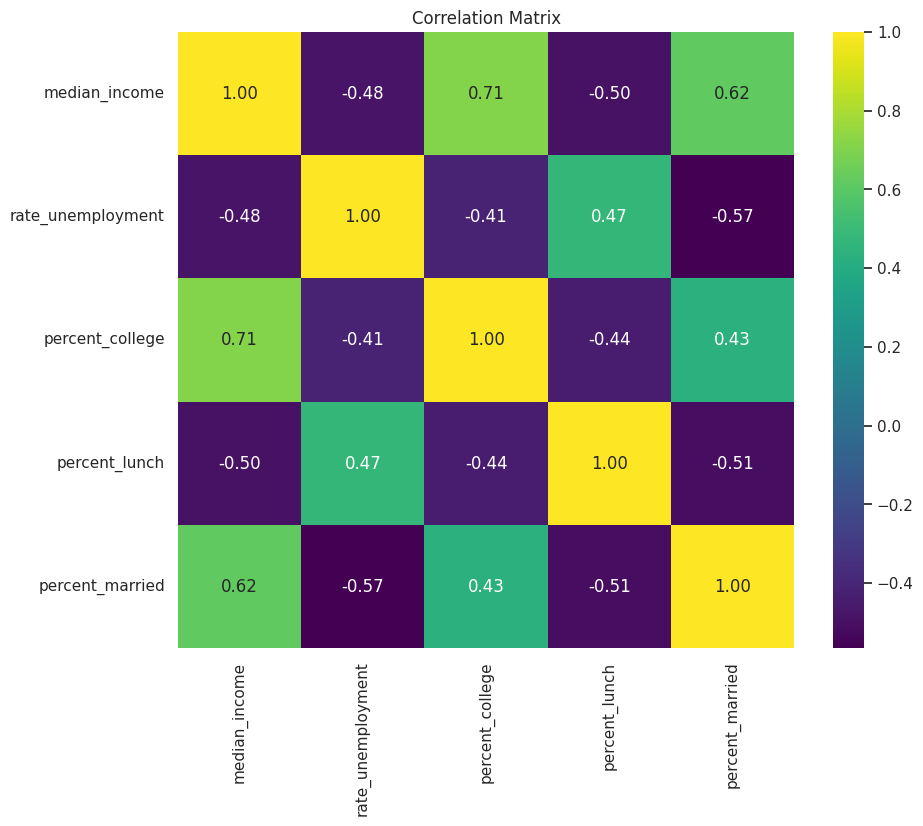

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df[['median_income', 'rate_unemployment', 'percent_college', 'percent_lunch', 'percent_married']].corr()

# Plotting the correlation matrix with a different color range
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

### Visualizations

Below is scatter plot showing the average ACT scores of counties based on the percent of homes in the county that are occupied by college educated adults.

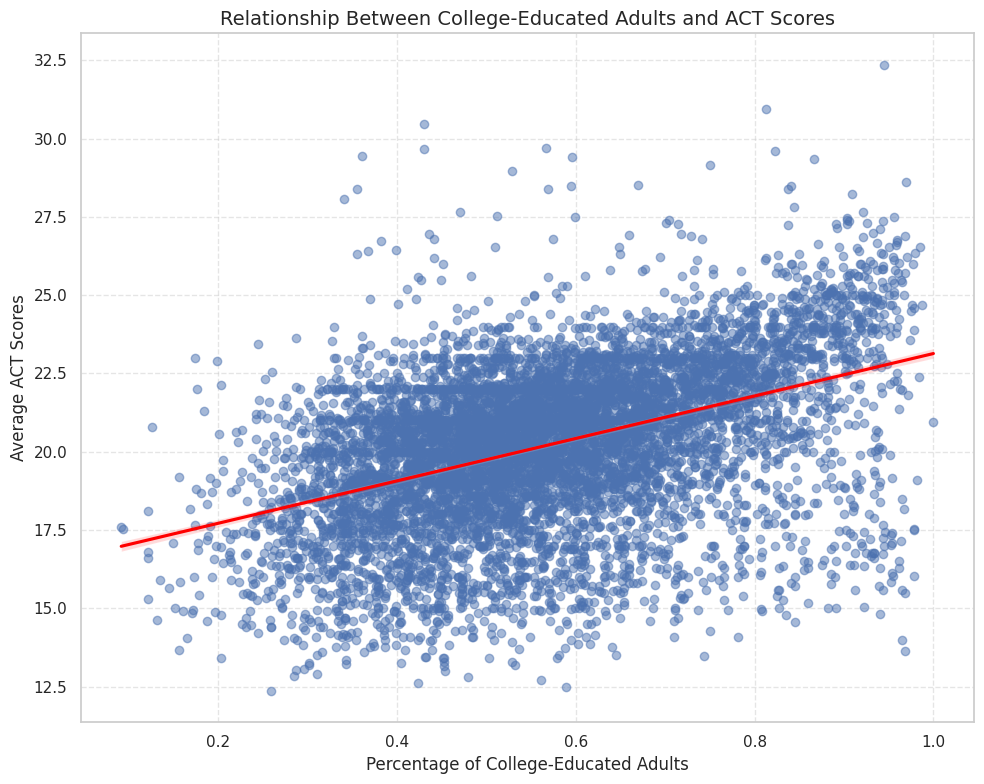

In [59]:
plt.figure(figsize=(10, 8))

sns.regplot(x='percent_college', y='average_act', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('Relationship Between College-Educated Adults and ACT Scores', fontsize=14)
plt.xlabel('Percentage of College-Educated Adults', fontsize=12)
plt.ylabel('Average ACT Scores', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Below is a scatter plot showing how counties rank in terms of how many houseolds have internet access vs their average ACT score.

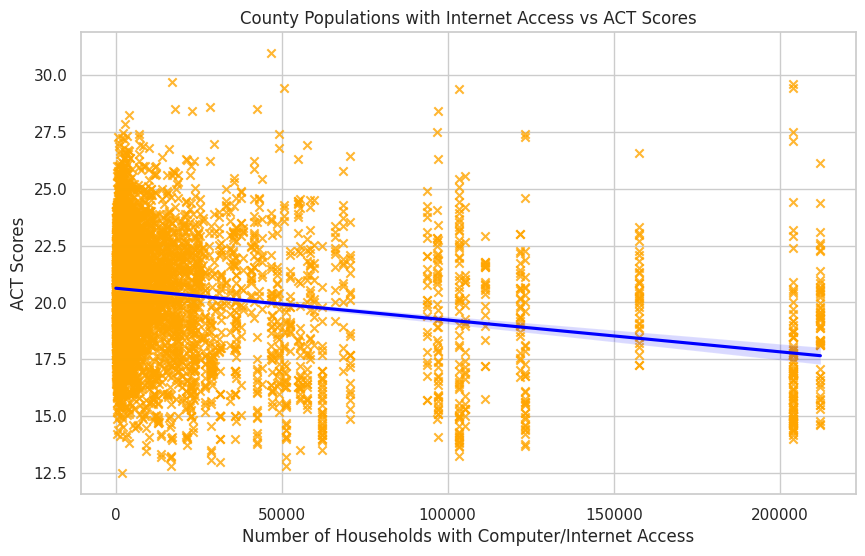

In [68]:
internet_df['comp_int_access'] = pd.to_numeric(internet_df['comp_int_access'], errors='coerce')
internet_df['average_act'] = pd.to_numeric(internet_df['average_act'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.regplot(x='comp_int_access', y='average_act', data=internet_df, color='orange', line_kws={'color': 'blue'}, marker='x', ci=95)
plt.title('County Populations with Internet Access vs ACT Scores')
plt.xlabel('Number of Households with Computer/Internet Access')
plt.ylabel('ACT Scores')

# Show the plot
plt.show()

## Conclusion

Provide a brief description of your conclusions.

We conclude that there is not a noticeable difference between internet access and average ACT scores based on the data given. However, there is a overall correlation betwen socioeconomic facotrs and ACT scores that we can see in our correlation matrix. Something I think could be inportant to look in to is to see the number of people who even attempt to take the ACT and compare them to those who have never taken it along with thier socioeconomic factors.